In [1]:
# coding: utf-8 定義所有需要的含式
import io
from numbers import Number
import re

import numpy as np
from scipy import interpolate


class EmptyFileError(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


class FileNotSupportedError(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


def open_rri(pathname_or_fileobj):
    if isinstance(pathname_or_fileobj, str):
        rri = _open_rri_from_path(pathname_or_fileobj)
    elif isinstance(pathname_or_fileobj, io.TextIOWrapper):
        rri = _open_rri_from_fileobj(pathname_or_fileobj)
    return _transform_rri(rri)


def _open_rri_from_path(pathname):
    if pathname.endswith('.txt'):
        with open(pathname, 'r') as fileobj:
            rri = _open_rri_from_fileobj(fileobj)
    elif pathname.endswith('.hrm'):
        with open(pathname, 'r') as fileobj:
            rri = _open_rri_from_fileobj(fileobj)
    else:
        raise FileNotSupportedError("File extension not supported")
    return rri


def _open_rri_from_fileobj(fileobj):
    file_content = fileobj.read()
    file_type = _identify_rri_file_type(file_content)
    if file_type == 'text':
        rri = _open_rri_from_text(file_content)
        if not rri:
            raise EmptyFileError('File without rri data')
    else:
        rri = _open_rri_from_hrm(file_content)
        if not rri:
            raise EmptyFileError('File without rri data')
    return rri


def _open_rri_from_text(file_content):##----------------------------------------
    rri = list(map(float,
                   re.findall(r'\S+' , file_content)))
    return rri


def _open_rri_from_hrm(file_content):
    rri_info_index = file_content.find('[HRData]')
    rri = None
    if rri_info_index >= 0:
        rri = list(map(float,
                       re.findall(r'\d+', file_content[rri_info_index:-1])))
    return rri


def _identify_rri_file_type(file_content):
    is_hrm_file = file_content.find('[HRData]')
    if is_hrm_file >= 0:
        file_type = 'hrm'
    else:
        rri_lines = file_content.split('\n')
        for line in rri_lines:
            current_line_number = re.findall(r'\d+', line)
            if current_line_number:
                if  current_line_number[0] == line.strip():
                    raise FileNotSupportedError('Text file not supported')
        file_type = 'text'
    return file_type


def validate_rri(func):
    def _validate(rri, *args, **kwargs):
        _validate_positive_numbers(rri)
        rri = _transform_rri(rri)
        return func(rri, *args, **kwargs)

    def _validate_positive_numbers(rri):
        if not all(map(lambda value: isinstance(value, Number) and value > 0,
                       rri)):
            raise ValueError('rri must be a list or numpy.ndarray of positive'
                             ' and non-zero numbers')

    return _validate


def _transform_rri(rri):
    rri = _transform_rri_to_miliseconds(rri)
    return np.array(rri)


def validate_frequency_domain_arguments(func):
    def _check_frequency_domain_arguments(rri, fs=4.0, method='welch',
                                          interp_method='cubic', **kwargs):
        _validate_available_methods(method)
        return func(rri, fs, method, interp_method, **kwargs)

    def _validate_available_methods(method):
        available_methods = ('welch', 'ar')
        if method not in available_methods:
            raise ValueError('Method not supported! Choose among: {}'.format(
                ', '.join(available_methods)))

    return _check_frequency_domain_arguments


def _create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # make it seconds
    return rri_time - rri_time[0]   # force it to start at zero


def _transform_rri_to_miliseconds(rri):
    if np.median(rri) < 1:
        rri *= 1000
    return rri


def _interpolate_rri(rri, fs=4, interp_method='cubic'):
    if interp_method == 'cubic':
        return _interp_cubic_spline(rri, fs)
    elif interp_method == 'linear':
        return _interp_linear(rri, fs)


def _interp_cubic_spline(rri, fs):
    time_rri = _create_time_info(rri)
    time_rri_interp = _create_interp_time(rri, fs)
    tck = interpolate.splrep(time_rri, rri, s=0)
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)
    return time_rri_interp, rri_interp


def _interp_linear(rri, fs):
    time_rri = _create_time_info(rri)
    time_rri_interp = _create_interp_time(rri, fs)
    rri_interp = np.interp(time_rri_interp, time_rri, rri)
    return time_rri_interp, rri_interp


def _create_interp_time(rri, fs):
    time_rri = _create_time_info(rri)
    return np.arange(0, time_rri[-1], 1 / float(fs))



In [2]:
import tensorflow as tf
import numpy as np

# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.keras.backend.set_session(sess)

import tensorflow as tf
import matplotlib.pyplot as plt

#引入基本資料庫
from keras.datasets import mnist  
from keras.utils import np_utils  
import numpy as np  

Using TensorFlow backend.


In [3]:
#定義出normalize的函式
import numpy as np
class MapMinMaxApplier(object):
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
    def __call__(self, x):
        return x * self.slope + self.intercept
    def reverse(self, y):
        return (y-self.intercept) / self.slope
 
def mapminmax(x, ymin=-1, ymax=+1):
	x = np.asanyarray(x)
	xmax = x.max(axis=-1)
	xmin = x.min(axis=-1)
	if (xmax==xmin).any():
		raise ValueError("some rows have no variation")
	slope = ((ymax-ymin) / (xmax - xmin))[:,np.newaxis]
	intercept = (-xmin*(ymax-ymin)/(xmax-xmin))[:,np.newaxis] + ymin
	ps = MapMinMaxApplier(slope, intercept)
	return ps(x), ps

'''#2維矩陣練習
a = [[1, 2 ,3 ],[ 56 ,78 ,9]]
#a = np.array(a)
a[1][2]'''

'''#2維矩陣的建立
HRVdata = []

with open(r'D:\HRV_9_25\all_x_1.txt','r') as f:
    a = f.readline()
a = a.split('  ')
#print(a)
for char1 in a:
    HRVdata.append(float(char1))
#print(HRVdata)

HRVdata=np.array(HRVdata)
HRVdata = HRVdata.reshape(9,25); 
#print(HRVdata)
'''

"#2維矩陣的建立\nHRVdata = []\n\nwith open(r'D:\\HRV_9_25\x07ll_x_1.txt','r') as f:\n    a = f.readline()\na = a.split('  ')\n#print(a)\nfor char1 in a:\n    HRVdata.append(float(char1))\n#print(HRVdata)\n\nHRVdata=np.array(HRVdata)\nHRVdata = HRVdata.reshape(9,25); \n#print(HRVdata)\n"

In [4]:
#STEP1. 資料讀取與轉換 python3  
from os import walk
from os.path import join

# 指定要列出所有檔案的目錄
mypath = "D:\HRV_9_25"
#將資料歸零
HRVdata=[]

# 遞迴列出所有檔案的絕對路徑
for root, dirs, files in walk(mypath):
  for f in files:
    fullpath = join(root, f)
    #print(fullpath)
    
    test=[]
    with open(fullpath,'r') as f:
        test = f.readline()
    test = test.split('  ')
    #print(a)
    #HRVdata=[]
    for char1 in test:
        HRVdata.append(float(char1))
        
HRVdata = np.array(HRVdata)

HRVdata = HRVdata.reshape(172,225)

#print(HRVdata[0])

In [5]:
#進行輸入矩陣的normalize
HRVdata,ps1=mapminmax(HRVdata,-1,1); #默认为-1,1
HRVdata = HRVdata.reshape(172,9,25,1)
#print(HRVdata[0])

In [6]:
# 0有asthma、1沒有asthma
label = []

with open(r'D:\all_y.txt','r') as f:
    a = f.readline()
a = a.split('  ')
#print(a)
for char1 in a:
    label.append(float(char1)-1)
    
#print(label)

# Label 的 Onehot encoding 
labelOneHot = np_utils.to_categorical(label)  

#print(labelOneHot[1])
#print(labelOneHot[1].size)
#以上完成輸入X及Y的基本設置

In [7]:
#STEP1. 建立卷積層與池化層 
from keras.models import Sequential  
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D  
  
model = Sequential()  
# Create CN layer 1  
model.add(Conv2D(filters=52,
                 kernel_size=(1,9),
                 padding='same',  
                 input_shape=(9,25,1),  
                 activation='relu'))  
# Create Max-Pool 1  
model.add(MaxPooling2D(pool_size=(2,2)))   
'''# Create CN layer 2 
model.add(Conv2D(filters=26,
                 kernel_size=(1,9),
                 padding='same',  
                 input_shape=(9,25,1),  
                 activation='relu'))  
# Create Max-Pool 2  
model.add(MaxPooling2D(pool_size=(2,2)))   

# Add Dropout layer  
#model.add(Dropout(0.25))  '''

#STEP2. 建立神經網路 
#建立平坦層 
#下面程式碼建立平坦層, 將之前步驟已經建立的池化層2
model.add(Flatten()) 

#建立 Hidden layer 
model.add(Dense(255, activation='relu'))  
model.add(Dropout(0.25)) 

#建立輸出層 
#最後建立輸出層, 共有 2 個神經元, 對應到 0~1 共兩個結果. 並使用 softmax 激活函數 進行轉換 (softmax 函數可以將神經元的輸出轉換成每一個數字的機率):
model.add(Dense(2, activation='softmax')) 

In [8]:
#STEP3. 查看模型的摘要
model.summary()  
print("")  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 25, 52)         520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 12, 52)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 255)               636735    
_________________________________________________________________
dropout_1 (Dropout)          (None, 255)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 512       
Total params: 637,767
Trainable params: 637,767
Non-trainable params: 0
_________________________________________________________________



In [9]:
#STEP1. 定義訓練並進行訓練 
# 定義訓練方式  
#print(len(HRVdata),len(labelOneHot))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
  
# 開始訓練  
train_history = model.fit(x=HRVdata,  
                          y=labelOneHot, validation_split=0.33,  
                          epochs=1000, batch_size=1, verbose=1)  

Train on 115 samples, validate on 57 samples
Epoch 1/1000
115/115 [==============================] - 2s 17ms/step - loss: 0.6522 - acc: 0.7304 - val_loss: 1.1790 - val_acc: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.5868 - acc: 0.7478 - val_loss: 1.6602 - val_acc: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.5820 - acc: 0.7478 - val_loss: 1.1922 - val_acc: 0.0000e+00
Epoch 4/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.5445 - acc: 0.7478 - val_loss: 1.6813 - val_acc: 0.0000e+00
Epoch 5/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.5560 - acc: 0.7478 - val_loss: 1.2765 - val_acc: 0.0000e+00
Epoch 6/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.5677 - acc: 0.7478 - val_loss: 1.3905 - val_acc: 0.0000e+00
Epoch 7/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.5376 - acc: 0.7478 - val_loss: 2.1989 - va

115/115 [==============================] - 1s 13ms/step - loss: 0.3752 - acc: 0.8087 - val_loss: 3.0530 - val_acc: 0.1053
Epoch 61/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3578 - acc: 0.8435 - val_loss: 3.6081 - val_acc: 0.0526
Epoch 62/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3485 - acc: 0.8348 - val_loss: 4.0211 - val_acc: 0.1228
Epoch 63/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3530 - acc: 0.8348 - val_loss: 3.9049 - val_acc: 0.0526
Epoch 64/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3538 - acc: 0.8261 - val_loss: 3.1939 - val_acc: 0.2105
Epoch 65/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3722 - acc: 0.8261 - val_loss: 3.8527 - val_acc: 0.1228
Epoch 66/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.3489 - acc: 0.8261 - val_loss: 3.8381 - val_acc: 0.1053
Epoch 67/1000
115/115 [==============================] - 1s 12

Epoch 120/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2668 - acc: 0.8522 - val_loss: 4.7722 - val_acc: 0.2105
Epoch 121/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2710 - acc: 0.8783 - val_loss: 4.7779 - val_acc: 0.1579
Epoch 122/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2284 - acc: 0.9130 - val_loss: 5.9177 - val_acc: 0.0877
Epoch 123/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2589 - acc: 0.8870 - val_loss: 5.2612 - val_acc: 0.1404
Epoch 124/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2695 - acc: 0.8783 - val_loss: 5.3501 - val_acc: 0.1228
Epoch 125/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2607 - acc: 0.8783 - val_loss: 5.9128 - val_acc: 0.0526
Epoch 126/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2619 - acc: 0.8696 - val_loss: 5.2472 - val_acc: 0.0877
Epoch 127/1000
115/115 [=================

Epoch 180/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1884 - acc: 0.9130 - val_loss: 5.7626 - val_acc: 0.1930
Epoch 181/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1708 - acc: 0.9130 - val_loss: 6.4740 - val_acc: 0.0702
Epoch 182/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1809 - acc: 0.9130 - val_loss: 6.4234 - val_acc: 0.0702
Epoch 183/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1656 - acc: 0.9304 - val_loss: 5.6980 - val_acc: 0.2281
Epoch 184/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1965 - acc: 0.9043 - val_loss: 5.9022 - val_acc: 0.1579
Epoch 185/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1660 - acc: 0.9304 - val_loss: 6.7621 - val_acc: 0.0702
Epoch 186/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.1771 - acc: 0.8957 - val_loss: 6.4944 - val_acc: 0.0877
Epoch 187/1000
115/115 [=================

Epoch 240/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1201 - acc: 0.9391 - val_loss: 7.2829 - val_acc: 0.1228
Epoch 241/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1065 - acc: 0.9565 - val_loss: 6.6222 - val_acc: 0.1930
Epoch 242/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1241 - acc: 0.9478 - val_loss: 6.0710 - val_acc: 0.3684
Epoch 243/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1089 - acc: 0.9652 - val_loss: 7.0061 - val_acc: 0.1930
Epoch 244/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.1147 - acc: 0.9478 - val_loss: 6.2541 - val_acc: 0.3509
Epoch 245/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1152 - acc: 0.9565 - val_loss: 6.7740 - val_acc: 0.2456
Epoch 246/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0990 - acc: 0.9565 - val_loss: 7.2982 - val_acc: 0.1579
Epoch 247/1000
115/115 [=================

Epoch 300/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0787 - acc: 0.9652 - val_loss: 8.6089 - val_acc: 0.0526
Epoch 301/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0648 - acc: 0.9826 - val_loss: 7.5662 - val_acc: 0.1930
Epoch 302/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0813 - acc: 0.9739 - val_loss: 6.9490 - val_acc: 0.1930
Epoch 303/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1027 - acc: 0.9565 - val_loss: 7.9506 - val_acc: 0.1228
Epoch 304/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0791 - acc: 0.9652 - val_loss: 7.3745 - val_acc: 0.2456
Epoch 305/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0747 - acc: 0.9739 - val_loss: 8.7892 - val_acc: 0.1053
Epoch 306/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0824 - acc: 0.9565 - val_loss: 7.5136 - val_acc: 0.2456
Epoch 307/1000
115/115 [=================

Epoch 360/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0514 - acc: 0.9739 - val_loss: 8.3052 - val_acc: 0.2105
Epoch 361/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0174 - acc: 1.0000 - val_loss: 8.6303 - val_acc: 0.1579
Epoch 362/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0554 - acc: 0.9913 - val_loss: 7.8874 - val_acc: 0.1754
Epoch 363/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0584 - acc: 0.9826 - val_loss: 8.6705 - val_acc: 0.1579
Epoch 364/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0294 - acc: 1.0000 - val_loss: 8.1336 - val_acc: 0.1930
Epoch 365/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.2177 - acc: 0.9565 - val_loss: 7.0176 - val_acc: 0.1930
Epoch 366/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1887 - acc: 0.9217 - val_loss: 7.5524 - val_acc: 0.2281
Epoch 367/1000
115/115 [=================

Epoch 420/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0537 - acc: 0.9826 - val_loss: 9.1702 - val_acc: 0.1228
Epoch 421/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0249 - acc: 0.9913 - val_loss: 8.8342 - val_acc: 0.1228
Epoch 422/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0503 - acc: 0.9913 - val_loss: 8.8003 - val_acc: 0.1579
Epoch 423/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0539 - acc: 0.9913 - val_loss: 9.1780 - val_acc: 0.1404
Epoch 424/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0199 - acc: 1.0000 - val_loss: 8.7515 - val_acc: 0.1754
Epoch 425/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0246 - acc: 0.9913 - val_loss: 8.2639 - val_acc: 0.1930
Epoch 426/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0414 - acc: 0.9826 - val_loss: 9.3681 - val_acc: 0.1053
Epoch 427/1000
115/115 [=================

Epoch 480/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0249 - acc: 1.0000 - val_loss: 8.4222 - val_acc: 0.2281
Epoch 481/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0212 - acc: 0.9913 - val_loss: 8.2757 - val_acc: 0.2456
Epoch 482/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0214 - acc: 1.0000 - val_loss: 8.9703 - val_acc: 0.1579
Epoch 483/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0372 - acc: 0.9826 - val_loss: 9.2190 - val_acc: 0.1228
Epoch 484/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 9.1861 - val_acc: 0.1579
Epoch 485/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.0178 - acc: 0.9913 - val_loss: 8.8041 - val_acc: 0.1930
Epoch 486/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 8.7177 - val_acc: 0.2281
Epoch 487/1000
115/115 [=================

Epoch 540/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 9.4166 - val_acc: 0.1228
Epoch 541/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0197 - acc: 0.9826 - val_loss: 7.9282 - val_acc: 0.2807
Epoch 542/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 8.4231 - val_acc: 0.2456
Epoch 543/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 9.3326 - val_acc: 0.1579
Epoch 544/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0223 - acc: 0.9913 - val_loss: 9.2993 - val_acc: 0.1404
Epoch 545/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0087 - acc: 1.0000 - val_loss: 8.9905 - val_acc: 0.1930
Epoch 546/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0311 - acc: 0.9913 - val_loss: 8.3749 - val_acc: 0.2281
Epoch 547/1000
115/115 [=================

Epoch 600/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0087 - acc: 1.0000 - val_loss: 9.2020 - val_acc: 0.1930
Epoch 601/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 9.6593 - val_acc: 0.1404
Epoch 602/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 9.5875 - val_acc: 0.1579
Epoch 603/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 9.6100 - val_acc: 0.1404
Epoch 604/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 9.6571 - val_acc: 0.1404
Epoch 605/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 9.2498 - val_acc: 0.1754
Epoch 606/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 9.5122 - val_acc: 0.1579
Epoch 607/1000
115/115 [=================

Epoch 660/1000
115/115 [==============================] - 1s 13ms/step - loss: 0.0288 - acc: 0.9913 - val_loss: 8.3582 - val_acc: 0.1579
Epoch 661/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 8.5881 - val_acc: 0.1754
Epoch 662/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0180 - acc: 1.0000 - val_loss: 10.1896 - val_acc: 0.1228
Epoch 663/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0790 - acc: 0.9652 - val_loss: 8.8190 - val_acc: 0.2105
Epoch 664/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0260 - acc: 0.9913 - val_loss: 8.1462 - val_acc: 0.2281
Epoch 665/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0768 - acc: 0.9826 - val_loss: 8.1268 - val_acc: 0.1754
Epoch 666/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0315 - acc: 0.9913 - val_loss: 8.4700 - val_acc: 0.1579
Epoch 667/1000
115/115 [================

Epoch 720/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 9.4142 - val_acc: 0.1754
Epoch 721/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 9.7328 - val_acc: 0.1754
Epoch 722/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 9.4090 - val_acc: 0.1754
Epoch 723/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0165 - acc: 0.9913 - val_loss: 10.0564 - val_acc: 0.0877
Epoch 724/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0342 - acc: 0.9913 - val_loss: 9.4729 - val_acc: 0.1754
Epoch 725/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0132 - acc: 0.9913 - val_loss: 9.8262 - val_acc: 0.1404
Epoch 726/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0088 - acc: 1.0000 - val_loss: 10.1139 - val_acc: 0.1579
Epoch 727/1000
115/115 [===============

Epoch 780/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0274 - acc: 0.9913 - val_loss: 8.7670 - val_acc: 0.1930
Epoch 781/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0495 - acc: 0.9739 - val_loss: 9.7236 - val_acc: 0.1579
Epoch 782/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0305 - acc: 0.9913 - val_loss: 9.9056 - val_acc: 0.1404
Epoch 783/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 9.7376 - val_acc: 0.1404
Epoch 784/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0210 - acc: 0.9913 - val_loss: 9.6347 - val_acc: 0.1754
Epoch 785/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0166 - acc: 0.9913 - val_loss: 9.0131 - val_acc: 0.1930
Epoch 786/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0100 - acc: 1.0000 - val_loss: 9.7265 - val_acc: 0.1404
Epoch 787/1000
115/115 [=================

115/115 [==============================] - 1s 12ms/step - loss: 0.0232 - acc: 0.9913 - val_loss: 9.5655 - val_acc: 0.1579
Epoch 840/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0128 - acc: 1.0000 - val_loss: 10.0611 - val_acc: 0.1579
Epoch 841/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0577 - acc: 0.9913 - val_loss: 8.6394 - val_acc: 0.2105
Epoch 842/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 9.3102 - val_acc: 0.1754
Epoch 843/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 9.8036 - val_acc: 0.1404
Epoch 844/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 9.2524 - val_acc: 0.1579
Epoch 845/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 9.2575 - val_acc: 0.1754
Epoch 846/1000
115/115 [==============================]

115/115 [==============================] - 1s 12ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 9.3249 - val_acc: 0.2456
Epoch 899/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.1568 - acc: 0.9478 - val_loss: 9.7032 - val_acc: 0.1930
Epoch 900/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0367 - acc: 0.9826 - val_loss: 8.2320 - val_acc: 0.2456
Epoch 901/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 9.4081 - val_acc: 0.1930
Epoch 902/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0486 - acc: 0.9913 - val_loss: 9.3864 - val_acc: 0.1579
Epoch 903/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 9.5389 - val_acc: 0.1579
Epoch 904/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 9.3639 - val_acc: 0.1579
Epoch 905/1000
115/115 [==============================] 

Epoch 958/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0162 - acc: 0.9913 - val_loss: 8.3744 - val_acc: 0.2807
Epoch 959/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 10.1123 - val_acc: 0.1228
Epoch 960/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 9.2090 - val_acc: 0.1579
Epoch 961/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 8.8691 - val_acc: 0.2105
Epoch 962/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 8.8153 - val_acc: 0.2456
Epoch 963/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0484 - acc: 0.9913 - val_loss: 9.4127 - val_acc: 0.1930
Epoch 964/1000
115/115 [==============================] - 1s 12ms/step - loss: 0.0424 - acc: 0.9739 - val_loss: 9.6293 - val_acc: 0.1579
Epoch 965/1000
115/115 [================

In [10]:
import os  
  
def isDisplayAvl():  
    return 'DISPLAY' in os.environ.keys()  
  
import matplotlib.pyplot as plt  
def plot_image(image):  
    fig = plt.gcf()  
    fig.set_size_inches(2,2)  
    plt.imshow(image, cmap='binary')  
    plt.show()  
  
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()  
  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show() 

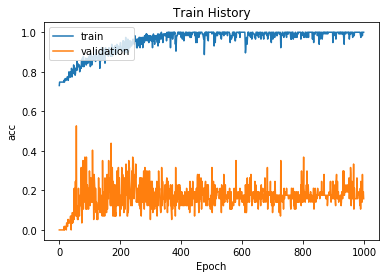

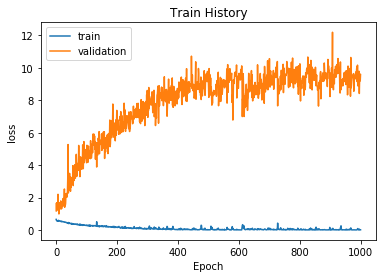

In [11]:
#from utils import *  
#if isDisplayAvl():  
show_train_history(train_history, 'acc', 'val_acc')  
show_train_history(train_history, 'loss', 'val_loss') 

In [18]:
scores = model.evaluate(HRVdata, labelOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0)) 

172/172 [==============================] - 0s 304us/step

	[Info] Accuracy of testing data = 89.5%


In [19]:
print("\t[Info] Making prediction of X_Test4D_norm")  
prediction = model.predict_classes(HRVdata)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 172 prediction result (From 1):")  
print("%s\n" % (prediction[0:172])) 

	[Info] Making prediction of X_Test4D_norm

	[Info] Show 172 prediction result (From 1):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0
 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0]



In [20]:
#存設計好之model-------------------------------

model.save('my_model_new.h5')   # HDF5 file, you have to pip3 install h5py if don't have it
del model  # deletes the existing model


In [23]:
#讀進存好之model並測試是否test出來結果一樣
from keras.models import load_model
model = load_model('my_model.h5')
scores = model.evaluate(HRVdata, labelOneHot)  
print()  
print("\t[Info] Accuracy of testing data after load = {:2.1f}%".format(scores[1]*100.0)) 

print("\t[Info] Making prediction of X_Test4D_norm")  
prediction = model.predict_classes(HRVdata)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 172 prediction result (From 1):")  
print("%s\n" % (prediction[0:172])) 

172/172 [==============================] - 0s 443us/step

	[Info] Accuracy of testing data after load = 81.4%
	[Info] Making prediction of X_Test4D_norm

	[Info] Show 172 prediction result (From 1):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0]

